In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Configuration pour l'affichage
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8-whitegrid')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Partie 1 : Résolution simplifiée par Programmation Dynamique (Value Iteration)

On considère un cas simplifié avec :
- Un actif risqué et un actif sans risque (cash) ($r=0$).
- un horizon fini $T$ .
- Objectif : Maximiser la capital terminal $B_T$.


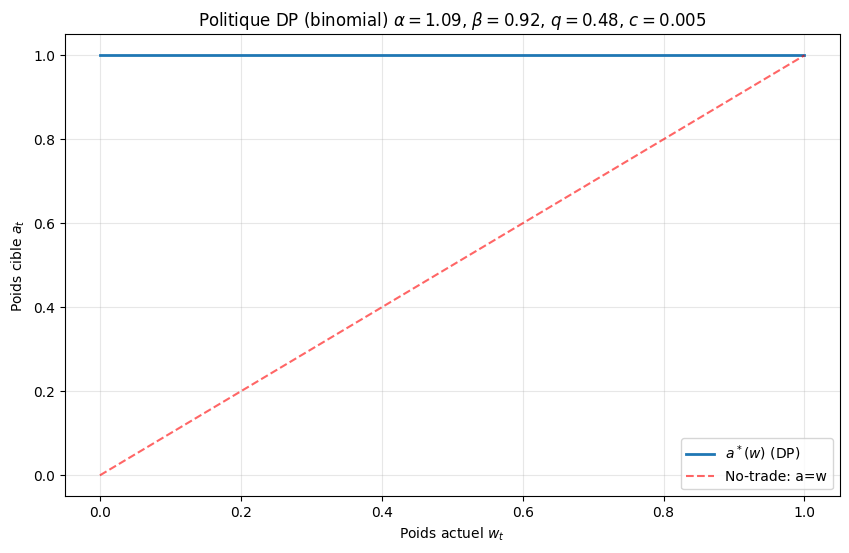

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


N_w = 101  # Grilles
W = np.linspace(0.0, 1.0, N_w)       # états w_t
A = np.linspace(0.0, 1.0, N_w)       # actions a_t 
T_horizon = 20  # Horizon temporel
gamma = 0.99  # Facteur d'actualisation

# Binomial price model
alpha = 1.09   # hausse
beta  = 0.92   # baisse
q = 0.48  # probabilite

# Coût de transaction 
c = 0.005

# Normalisation du capital 
B0 = 1.0

# V[t, i] = valeur à la date t quand w = W[i]
V = np.zeros((T_horizon + 1, N_w))
Policy = np.zeros((T_horizon, N_w))

# Condition terminale (Backward Induction) : V_T(w)=0 
V[T_horizon, :] = 0.0

def phi_1d(a, ratio):  # ratio = p'/p
    denom = a * ratio + (1 - a)
    return (a * ratio) / denom

for t in range(T_horizon - 1, -1, -1):  # start=T_horizon-1, stop=-1, step=-1
    for i, w in enumerate(W):

        best_val = -np.inf  # initialisation
        best_a = w  

        for a in A:
            cost_frac = c * abs(a - w)        
            B_after_cost = B0 * (1 - cost_frac)

            # 2) ratio_up = alpha, ratio_down = beta
            # 2a) Poids après évolution des prix : w' = phi(a, p, p')
            w_up = phi_1d(a, alpha)
            w_dn = phi_1d(a, beta)

            # 2b) Capital après évolution des prix
            # 1 actif risqué + cash
            # B' = B(1 - c|a-w|) * ( a*(p'/p) + (1-a)*1 )
            B_up = B_after_cost * (a * alpha + (1 - a))
            B_dn = B_after_cost * (a * beta  + (1 - a))

            # 3) Reward r
            r_up = B_up - B0
            r_dn = B_dn - B0

            # 4) Valeur future : V(t+1, w') via interpolation sur la grille W
            v_up = np.interp(w_up, W, V[t+1, :])
            v_dn = np.interp(w_dn, W, V[t+1, :])

            # 5) Bellman
            val = q * (r_up + gamma * v_up) + (1 - q) * (r_dn + gamma * v_dn)

            if val > best_val:
                best_val = val
                best_a = a

        V[t, i] = best_val
        Policy[t, i] = best_a

# Plot politique à t=0
plt.figure(figsize=(10,6))
plt.plot(W, Policy[0, :], lw=2, label=r"$a^*(w)$ (DP)")
plt.plot(W, W, "r--", alpha=0.6, label="No-trade: a=w")
plt.title(fr"Politique DP (binomial) $\alpha={alpha}$, $\beta={beta}$, $q={q}$, $c={c}$")
plt.xlabel(r"Poids actuel $w_t$")
plt.ylabel(r"Poids cible $a_t$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Partie 2 : Apprentissage par Renforcement (PPO)

On passe maintenant au cas général (continu) avec un simulateur de marché.
L'environnement est défini selon le formalisme Gym.
Nous utilisons l'algorithme PPO (Proximal Policy Optimization) pour approximer la politique optimale $\pi_\theta$.

In [61]:
class TradingEnv(gym.Env):
    """
    Environnement d'allocation de portefeuille avec coûts de transaction.
    Modèle conforme à la section 4 du rapport.
    """
    def __init__(self, n_risky=3, shock_t=None, 
                 shock_asset=0, shock_factor=0.6, regime_t=None, 
                 regime_asset=0, mu_after=None, 
                 use_shock=True, use_regime=True, down_trend=0.985):
        super(TradingEnv, self).__init__()
        
        # Paramètres de marché
        self.initial_capital = 100.0
        self.trans_cost = 0.001  # 0.1% de frais
        self.n_steps = 100      # Longueur épisode
        self.mu = 0.01
        self.sigma = 0.02

        # Nombre d'actifs risqués
        self.n_risky = n_risky
        self.n_assets = self.n_risky + 1   # + cash

        # Choc
        self.shock_t = shock_t           
        self.shock_asset = shock_asset    # index 0..n_risky-1
        self.shock_factor = shock_factor  

        # Changement de régime 
        self.regime_t = regime_t            # instant à partir duquel le régime change
        self.regime_asset = regime_asset    # index 0..n_risky-1
        self.mu_after = mu_after            
        
        self.use_shock = use_shock
        self.use_regime = use_regime
        self.down_trend = down_trend
        # Espace d'action : allocation cible a_t dans [0, 1]
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_risky,), dtype=np.float32)
        
        # Espace d'observation : [w_t, p_t (relatif), B_t (relatif)]
        obs_dim = self.n_assets + self.n_risky + 1
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(obs_dim,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # self.use_regime = self.np_random.random() < 0.8

        self.capital = self.initial_capital
        self.w = np.zeros(self.n_assets)   # Poids initial
        self.w[-1] = 1.0
        self.price = np.ones(self.n_risky)
        self.t = 0
        
        return self._get_obs(), {}

    def _get_obs(self):
        # On normalise pour aider le réseau de neurones
        return np.concatenate([self.w, self.price, [self.capital / self.initial_capital]]).astype(np.float32)


    def step(self, action):
        # 1. Action: PPO propose des poids pour les actifs risqués
        a_r = np.clip(action, 0.0, 1.0).astype(np.float64)

        # Contraindre sum(a_r) <= 1 
        s = a_r.sum()
        if s > 1.0:
            a_r = a_r / (s + 1e-12)

        a_cash = 1.0 - a_r.sum()
        a = np.append(a_r, a_cash)  # a somme exactement à 1, et cash >= 0

        # Coût de transaction : C_t = c * B_t * |a_t - w_t|
        cost = self.trans_cost * self.capital * np.sum(np.abs(a - self.w))
        net_capital = self.capital - cost
        net_capital = max(net_capital, 1e-12)
        
        # 2) Dynamique des prix
        p_old = self.price.copy()
        risky_returns = self.np_random.normal(self.mu, self.sigma, size=self.n_risky)
        
        if self.use_regime and (self.regime_t is not None) and (self.t >= self.regime_t):
            if self.mu_after is not None:
                risky_returns[self.regime_asset] = self.np_random.normal(self.mu_after, self.sigma)
            
        self.price = p_old * (1.0 + risky_returns)

        # appliquer un choc de prix à t = shock_t 
        if self.use_regime and (self.regime_t is not None) and (self.t == self.regime_t):
            self.price[self.regime_asset] *= self.down_trend

        # Choc ponctuel
        if self.use_shock and (self.shock_t is not None) and (self.t == self.shock_t):
            self.price[self.shock_asset] *= self.shock_factor


        price_ratio = self.price / (p_old + 1e-12)   # p'/p
        cash_ratio = 1.0
        ratio = np.append(price_ratio, cash_ratio)  # longueur n_assets

        
        # 3. Mise à jour Capital (B_{t+1})
        # B_{t+1} = B_{net} * (a * (1+r) + (1-a) * 1)
        new_capital = net_capital * np.sum(a * (ratio))

        # 4. Mise à jour Poids (w_{t+1}) - Dérive due aux prix
        new_w = (a * (ratio)) / (np.sum(a * (ratio)) + 1e-12)
            
        # Convertir numpy.float en float python standard
        reward = float(new_capital - self.capital)
        
        # Mise à jour état interne
        self.capital = new_capital
        self.w = new_w
        self.t += 1
        
        terminated = bool((self.t >= self.n_steps) or (self.capital <= 0))
        
        return self._get_obs(), reward, terminated, False, {}

env = TradingEnv()
env.reset(seed=42)
check_env(env)
print("Environnement Gym validé.")

Environnement Gym validé.


In [30]:
print("Lancement de l'entraînement PPO")

# Instanciation de l'environnement
env = TradingEnv(shock_t=None, regime_t=None)

# Modèle PPO avec hyperparamètres standards
# MlpPolicy : Réseau de neurones dense 
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)

# Entraînement
model.learn(total_timesteps=100000)

print("Entraînement terminé.")

Lancement de l'entraînement PPO
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 83.3     |
| time/              |          |
|    fps             | 1490     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 83.2        |
| time/                   |             |
|    fps                  | 1082        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005482398 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.

# Partie 3 : Résultats et Comparaison

On compare la stratégie apprise par l'agent PPO (RL) face à deux stratégies de référence (Benchmarks) :
1. **Buy and Hold** : l’intégralité du capital est investie au temps initial sur un actif donné, sans réallocation ultérieure.
2. **Rebalancing Constant** : le portefeuille est réalloué à chaque pas de temps selon des poids fixes, ce qui engendre des coûts de transaction.

In [31]:
# Simulation PPO 
obs, _ = env.reset(seed=42)
done = False

capital_ppo = [env.initial_capital]
prices_hist = [env.price.copy()]   # ajout prix initiaux (n_risky)

for _ in range(env.n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)

    capital_ppo.append(env.capital)
    prices_hist.append(env.price.copy())  # ajout prix à chaque step

    if done:
        break

prices_hist = np.array(prices_hist)  # shape = (T+1, n_risky)


In [32]:
# Benchmarks : 100% Buy & Hold sur chaque actif risqué 
cap_bh1 = env.initial_capital * (prices_hist[:, 0] / prices_hist[0, 0])
cap_bh2 = env.initial_capital * (prices_hist[:, 1] / prices_hist[0, 1])
cap_bh3 = env.initial_capital * (prices_hist[:, 2] / prices_hist[0, 2])


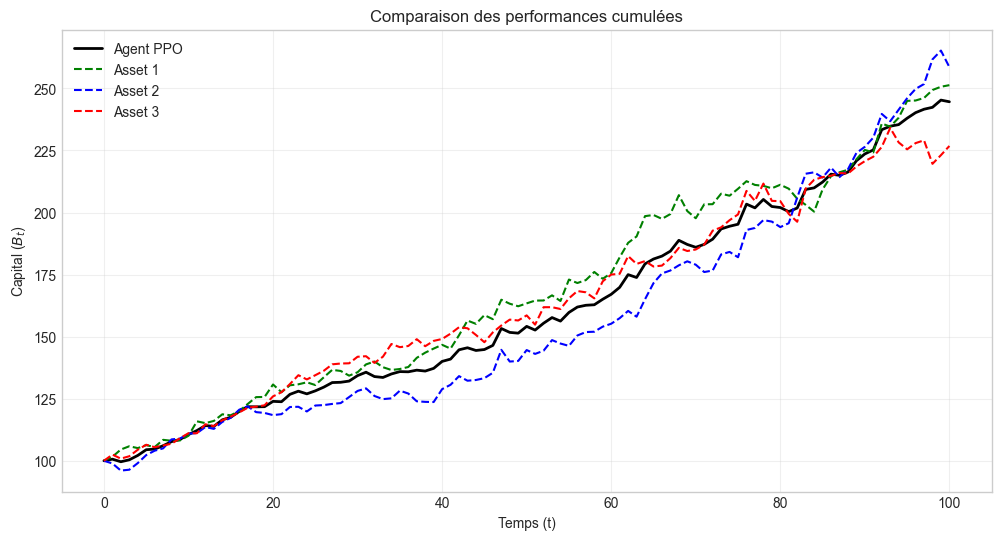

Capital Final PPO : 244.61
Capital Final Asset 1 : 251.30
Capital Final Asset 2 : 258.56
Capital Final Asset 3 : 226.80


In [33]:
t_axis = np.arange(len(capital_ppo))

plt.figure(figsize=(12, 6))
plt.plot(capital_ppo, label='Agent PPO', color='black', linewidth=2)

plt.plot(cap_bh1[:len(capital_ppo)], '--', color='green', label='Asset 1')
plt.plot(cap_bh2[:len(capital_ppo)], '--', color='blue', label='Asset 2')
plt.plot(cap_bh3[:len(capital_ppo)], '--', color='red', label='Asset 3')

plt.title("Comparaison des performances cumulées")
plt.xlabel("Temps (t)")
plt.ylabel("Capital ($B_t$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Capital Final PPO : {capital_ppo[-1]:.2f}")
print(f"Capital Final Asset 1 : {cap_bh1[len(capital_ppo)-1]:.2f}")
print(f"Capital Final Asset 2 : {cap_bh2[len(capital_ppo)-1]:.2f}")
print(f"Capital Final Asset 3 : {cap_bh3[len(capital_ppo)-1]:.2f}")


In [62]:
regime_t = 40
regime_asset = 1
mu_after = -0.05

env_regime = TradingEnv(
    use_shock=False,          
    use_regime=True,       
    regime_t=regime_t,
    regime_asset=regime_asset,
    mu_after=mu_after
)

env_regime.reset(seed=42)

model_regime = PPO("MlpPolicy", env_regime, verbose=0, learning_rate=3e-4)
model_regime.learn(total_timesteps=100000)



In [35]:
shock_t = 60
shock_asset = 1
shock_factor = 0.6

env_shock = TradingEnv(
    use_shock=True,           
    use_regime=False,         
    shock_t=shock_t,
    shock_asset=shock_asset,
    shock_factor=shock_factor
)

env_shock.reset(seed=42)

model_shock = PPO("MlpPolicy", env_shock, verbose=0, learning_rate=3e-4)
model_shock.learn(total_timesteps=100000)


In [70]:
env = env_regime
model = model_regime

# env = env_shock
# model = model_shock

In [72]:
# Simulation PPO 
obs, _ = env.reset(seed=42)
done = False

capital_ppo = [env.initial_capital]
prices_hist = [env.price.copy()]   # ajout prix initiaux (n_risky)

for _ in range(env.n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)

    capital_ppo.append(env.capital)
    prices_hist.append(env.price.copy())  # ajout prix à chaque step

    if done:
        break

prices_hist = np.array(prices_hist)  # shape = (T+1, n_risky)


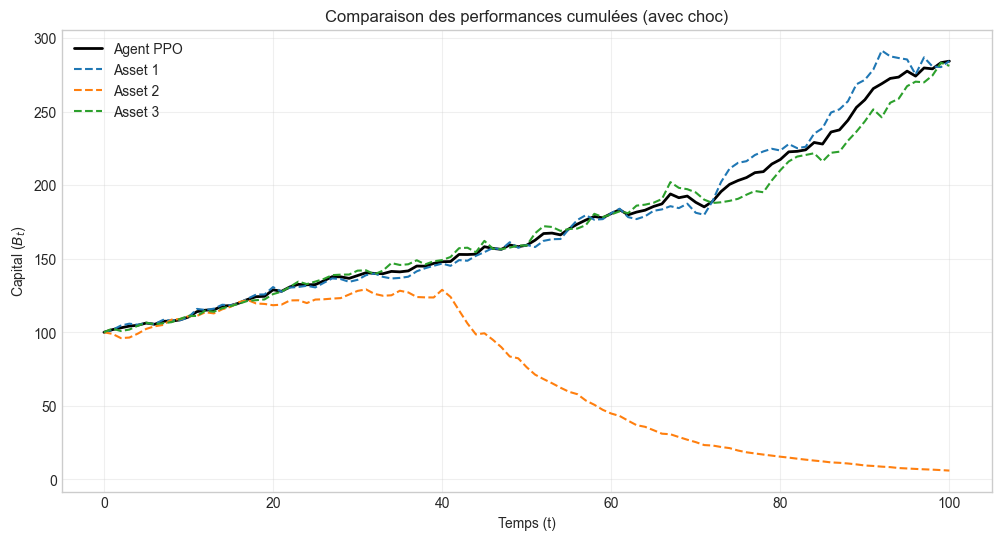

Capital Final PPO : 284.32
Capital Final Asset 1 : 284.41
Capital Final Asset 2 : 5.97
Capital Final Asset 3 : 281.15


In [73]:
obs, _ = env.reset(seed=42)
done = False

capital_ppo = [env.initial_capital]
prices_hist = [env.price.copy()]

for _ in range(env.n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)

    capital_ppo.append(env.capital)
    prices_hist.append(env.price.copy())

    if terminated or truncated:
        break

prices_hist = np.array(prices_hist)

cap_bh = env.initial_capital * (prices_hist / prices_hist[0])

T = len(capital_ppo)               
cap_bh = cap_bh[:T]

# Plot 
plt.figure(figsize=(12, 6))

plt.plot(capital_ppo, label="Agent PPO", linewidth=2, color="black")
plt.plot(cap_bh[:, 0], "--", label="Asset 1")
plt.plot(cap_bh[:, 1], "--", label="Asset 2")
plt.plot(cap_bh[:, 2], "--", label="Asset 3")

# Ligne verticale = choc
if env.shock_t is not None:
    plt.axvline(x=env.shock_t, linestyle=":", color="gray", linewidth=2, label="Choc")


plt.title("Comparaison des performances cumulées (avec choc)")
plt.xlabel("Temps (t)")
plt.ylabel("Capital ($B_t$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Capital Final PPO : {capital_ppo[-1]:.2f}")
print(f"Capital Final Asset 1 : {cap_bh[-1, 0]:.2f}")
print(f"Capital Final Asset 2 : {cap_bh[-1, 1]:.2f}")
print(f"Capital Final Asset 3 : {cap_bh[-1, 2]:.2f}")


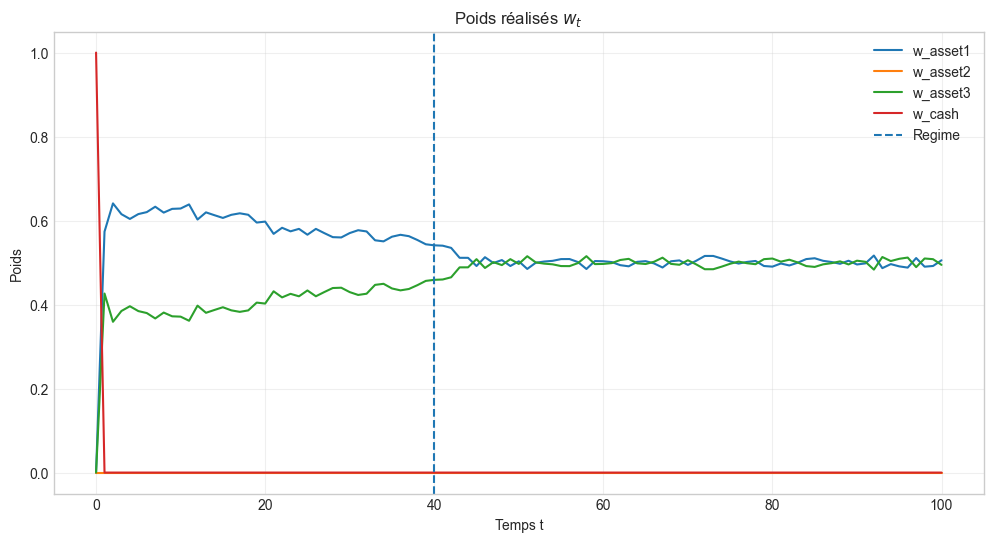

In [ ]:
obs, _ = env.reset(seed=42)
done = False

capital_ppo = [env.initial_capital]
prices_hist = [env.price.copy()]
w_hist = [env.w.copy()]    

for _ in range(env.n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)

    capital_ppo.append(env.capital)
    prices_hist.append(env.price.copy())
    w_hist.append(env.w.copy())

    if terminated or truncated:
        break

prices_hist = np.array(prices_hist)
w_hist = np.array(w_hist)

plt.figure(figsize=(12,6))
for i in range(env.n_risky):
    plt.plot(w_hist[:, i], label=f"w_asset{i+1}")
plt.plot(w_hist[:, -1], label="w_cash")

if env.shock_t is not None:
    plt.axvline(env.shock_t, linestyle=":", label="Choc")
if env.regime_t is not None:
    plt.axvline(env.regime_t, linestyle="--", label="Regime")

plt.title("Poids réalisés $w_t$")
plt.xlabel("Temps t")
plt.ylabel("Poids")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

